In [1]:
from bauer.utils.data import load_garcia2022
from bauer.models import MagnitudeComparisonModel
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = load_garcia2022()

In [3]:
df['choice'] = df['choice'] == 2.

In [4]:
model = MagnitudeComparisonModel(df.loc[:6])

In [5]:
model.build_estimation_model()

In [6]:
trace = model.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [evidence_sd1_mu_untransformed, evidence_sd1_sd, evidence_sd1_offset, evidence_sd2_mu_untransformed, evidence_sd2_sd, evidence_sd2_offset, n2_prior_mu_mu_untransformed, n2_prior_mu_sd, n2_prior_mu_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
ppc = model.ppc()

In [13]:
def summarize_ppc(ppc, groupby=None):

    if groupby is not None:
        ppc = ppc.groupby(groupby).mean()

    e = ppc.mean(1).to_frame('p_predicted')
    hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
                       columns=['hdi025', 'hdi975'])

    print(hdi)
    return pd.concat((e, hdi), axis=1)

In [14]:
summarize_ppc(ppc)

                                                       hdi025        hdi975
variable     subject trial_nr frac     n1 n2                               
ll_bernoulli 1       1        0.135335 7  1.0    1.000000e+00  1.000000e+00
                     2        0.135335 5  1.0    1.000000e+00  1.000000e+00
                     3        0.135335 28 4.0    1.000000e+00  1.000000e+00
                     4        0.135335 20 3.0    1.000000e+00  1.000000e+00
                     5        0.135335 10 1.0    1.000000e+00  1.000000e+00
...                                                       ...           ...
p            6       68       7.389056 5  37.0   1.000000e-09  2.186992e-06
                     69       7.389056 28 207.0  1.000000e-09  1.727402e-09
                     70       7.389056 20 148.0  1.000000e-09  7.237409e-09
                     71       7.389056 10 74.0   1.000000e-09  1.405296e-07
                     72       7.389056 14 103.0  1.000000e-09  3.715304e-08

[864 rows x

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_77392/3673296788.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


p_predicted        hdi025  \
variable     subject trial_nr frac     n1 n2                                  
ll_bernoulli 1       1        0.135335 7  1.0    1.000000e+00  1.000000e+00   
                     2        0.135335 5  1.0    1.000000e+00  1.000000e+00   
                     3        0.135335 28 4.0    1.000000e+00  1.000000e+00   
                     4        0.135335 20 3.0    1.000000e+00  1.000000e+00   
                     5        0.135335 10 1.0    1.000000e+00  1.000000e+00   
...                                                       ...           ...   
p            6       68       7.389056 5  37.0   6.657692e-07  1.000000e-09   
                     69       7.389056 28 207.0  1.454201e-09  1.000000e-09   
                     70       7.389056 20 148.0  3.209014e-09  1.000000e-09   
                     71       7.389056 10 74.0   4.467626e-08  1.000000e-09   
                     72       7.389056 14 103.0  1.258383e-08  1.000000e-09   

                                                       hdi975  
variable     subject trial_nr frac     n1 n2                   
ll_bernoulli 1       1        0.135335 7  1.0    1.000000e+00  
                     2        0.135335 5  1.0    1.000000e+00  
                     3        0.135335 28 4.0    1.000000e+00  
                     4        0.135335 20 3.0    1.000000e+00  
                     5        0.135335 10 1.0    1.000000e+00  
...                                                       ...  
p            6       68       7.389056 5  37.0   2.186992e-06  
                     69       7.389056 28 207.0  1.727402e-09  
                     70       7.389056 20 148.0  7.237409e-09  
                     71       7.389056 10 74.0   1.405296e-07  
                     72       7.389056 14 103.0  3.715304e-08  

[864 rows x 3 columns]

In [11]:
def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', 'log(risky/safe)']).size().groupby('subject').size() < 7).all():
        df['log(risky/safe)'] = df.groupby(['subject'],
                                        group_keys=False).apply(cluster_offers)

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc = ppc.reset_index('log(risky/safe)')
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')

    if plot_type == 1:
        groupby = ['risky_first', 'log(risky/safe)']
    elif plot_type in [2, 4]:
        groupby = ['risky_first', 'n_safe']
    elif plot_type in [3, 5]:
        groupby = ['risky_first', 'n_safe', 'log(risky/safe)']
    else:
        raise NotImplementedError

    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()

    if level == 'subject':
        groupby = ['subject'] + groupby

    print(ppc)
    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    print(ppc_summary)
    p = df.groupby(groupby).mean()[['chose_risky']]
    # ppc_summary = pd.concat((p, ppc_summary)).sort_index()
    ppc_summary = ppc_summary.join(p).reset_index()

    print(ppc_summary)
    ppc_summary['Order'] = ppc_summary['risky_first'].map({True:'Risky first', False:'Safe first'})

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if level == 'group':
        x = 'Predicted acceptance'
    else:
        x = 'Log-ratio offer'

    if plot_type in [1, 2]:
        if plot_type == 2:
            x = 'Safe offer'

        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Order',
                            col_wrap=col_wrap if level == 'subject' else None)

    elif plot_type == 3:
        fac = sns.FacetGrid(ppc_summary,
                            col='Safe offer',
                            hue='Order',
                            row='subject' if level == 'subject' else None)
    elif plot_type == 4:


        if level == 'group':
            rnp = df.groupby(['subject'] + groupby, group_keys=False).apply(get_rnp).to_frame('rnp')
            rnp = rnp.groupby(groupby).mean()
        else:
            rnp = df.groupby(groupby, group_keys=False).apply(get_rnp).to_frame('rnp')

        print(ppc_summary)
        print(rnp)
        ppc_summary = ppc_summary.join(rnp)
        print(ppc_summary)
        fac = sns.FacetGrid(ppc_summary,
                            hue='Order',
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None)

        print(ppc_summary)
        fac.map_dataframe(plot_prediction, x='Safe offer', y='p_predicted')
        fac.map(plt.scatter, 'Safe offer', 'rnp')
        fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))

    elif plot_type == 5:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='subject' if level == 'subject' else None,
                            palette='coolwarm')

    if plot_type in [1,2,3, 5]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [1, 3, 5]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(2.5, c='k', ls='--'))

    
    fac.add_legend()

    return fac


chain                                                       0                \
draw                                                      0             1     
variable     subject trial_nr frac     n1 n2                                  
ll_bernoulli 1       1        0.135335 7  1.0    1.000000e+00  1.000000e+00   
                     2        0.135335 5  1.0    1.000000e+00  1.000000e+00   
                     3        0.135335 28 4.0    1.000000e+00  1.000000e+00   
                     4        0.135335 20 3.0    1.000000e+00  1.000000e+00   
                     5        0.135335 10 1.0    1.000000e+00  1.000000e+00   
...                                                       ...           ...   
p            6       68       7.389056 5  37.0   1.000000e-09  1.592713e-07   
                     69       7.389056 28 207.0  1.000000e-09  1.000000e-09   
                     70       7.389056 20 148.0  1.000000e-09  1.000000e-09   
                     71       7.389056 10 74.0   1.000000e-09  7.449006e-09   
                     72       7.389056 14 103.0  1.000000e-09  1.678918e-09   

chain                                                                        \
draw                                                      2             3     
variable     subject trial_nr frac     n1 n2                                  
ll_bernoulli 1       1        0.135335 7  1.0    1.000000e+00  1.000000e+00   
                     2        0.135335 5  1.0    1.000000e+00  1.000000e+00   
                     3        0.135335 28 4.0    1.000000e+00  1.000000e+00   
                     4        0.135335 20 3.0    1.000000e+00  1.000000e+00   
                     5        0.135335 10 1.0    1.000000e+00  1.000000e+00   
...                                                       ...           ...   
p            6       68       7.389056 5  37.0   1.000000e-09  1.432455e-08   
                     69       7.389056 28 207.0  1.000000e-09  1.000000e-09   
                     70       7.389056 20 148.0  1.000000e-09  1.000000e-09   
                     71       7.389056 10 74.0   1.000000e-09  1.000000e-09   
                     72       7.389056 14 103.0  1.000000e-09  1.000000e-09   

chain                                                                        \
draw                                                      4             5     
variable     subject trial_nr frac     n1 n2                                  
ll_bernoulli 1       1        0.135335 7  1.0    1.000000e+00  1.000000e+00   
                     2        0.135335 5  1.0    1.000000e+00  1.000000e+00   
                     3        0.135335 28 4.0    1.000000e+00  1.000000e+00   
                     4        0.135335 20 3.0    1.000000e+00  1.000000e+00   
                     5        0.135335 10 1.0    1.000000e+00  1.000000e+00   
...                                                       ...           ...   
p            6       68       7.389056 5  37.0   6.893173e-08  1.684718e-07   
                     69       7.389056 28 207.0  1.000000e-09  1.000000e-09   
                     70       7.389056 20 148.0  1.000000e-09  1.000000e-09   
                     71       7.389056 10 74.0   3.800592e-09  1.063755e-08   
                     72       7.389056 14 103.0  1.000000e-09  2.816085e-09   

chain                                                                        \
draw                                                      6             7     
variable     subject trial_nr frac     n1 n2                                  
ll_bernoulli 1       1        0.135335 7  1.0    1.000000e+00  1.000000e+00   
                     2        0.135335 5  1.0    1.000000e+00  1.000000e+00   
                     3        0.135335 28 4.0    1.000000e+00  1.000000e+00   
                     4        0.135335 20 3.0    1.000000e+00  1.000000e+00   
                     5        0.135335 10 1.0    1.000000e+00  1.000000e+00   
...                                            

In [8]:
import arviz as az

array([[<AxesSubplot: title={'center': 'evidence_sd1_mu_untransformed'}>,
        <AxesSubplot: title={'center': 'evidence_sd1_mu_untransformed'}>],
       [<AxesSubplot: title={'center': 'evidence_sd1_offset'}>,
        <AxesSubplot: title={'center': 'evidence_sd1_offset'}>],
       [<AxesSubplot: title={'center': 'evidence_sd2_mu_untransformed'}>,
        <AxesSubplot: title={'center': 'evidence_sd2_mu_untransformed'}>],
       [<AxesSubplot: title={'center': 'evidence_sd2_offset'}>,
        <AxesSubplot: title={'center': 'evidence_sd2_offset'}>],
       [<AxesSubplot: title={'center': 'n2_prior_mu_mu_untransformed'}>,
        <AxesSubplot: title={'center': 'n2_prior_mu_mu_untransformed'}>],
       [<AxesSubplot: title={'center': 'n2_prior_mu_offset'}>,
        <AxesSubplot: title={'center': 'n2_prior_mu_offset'}>],
       [<AxesSubplot: title={'center': 'evidence_sd1_sd'}>,
        <AxesSubplot: title={'center': 'evidence_sd1_sd'}>],
       [<AxesSubplot: title={'center': 'evidence_

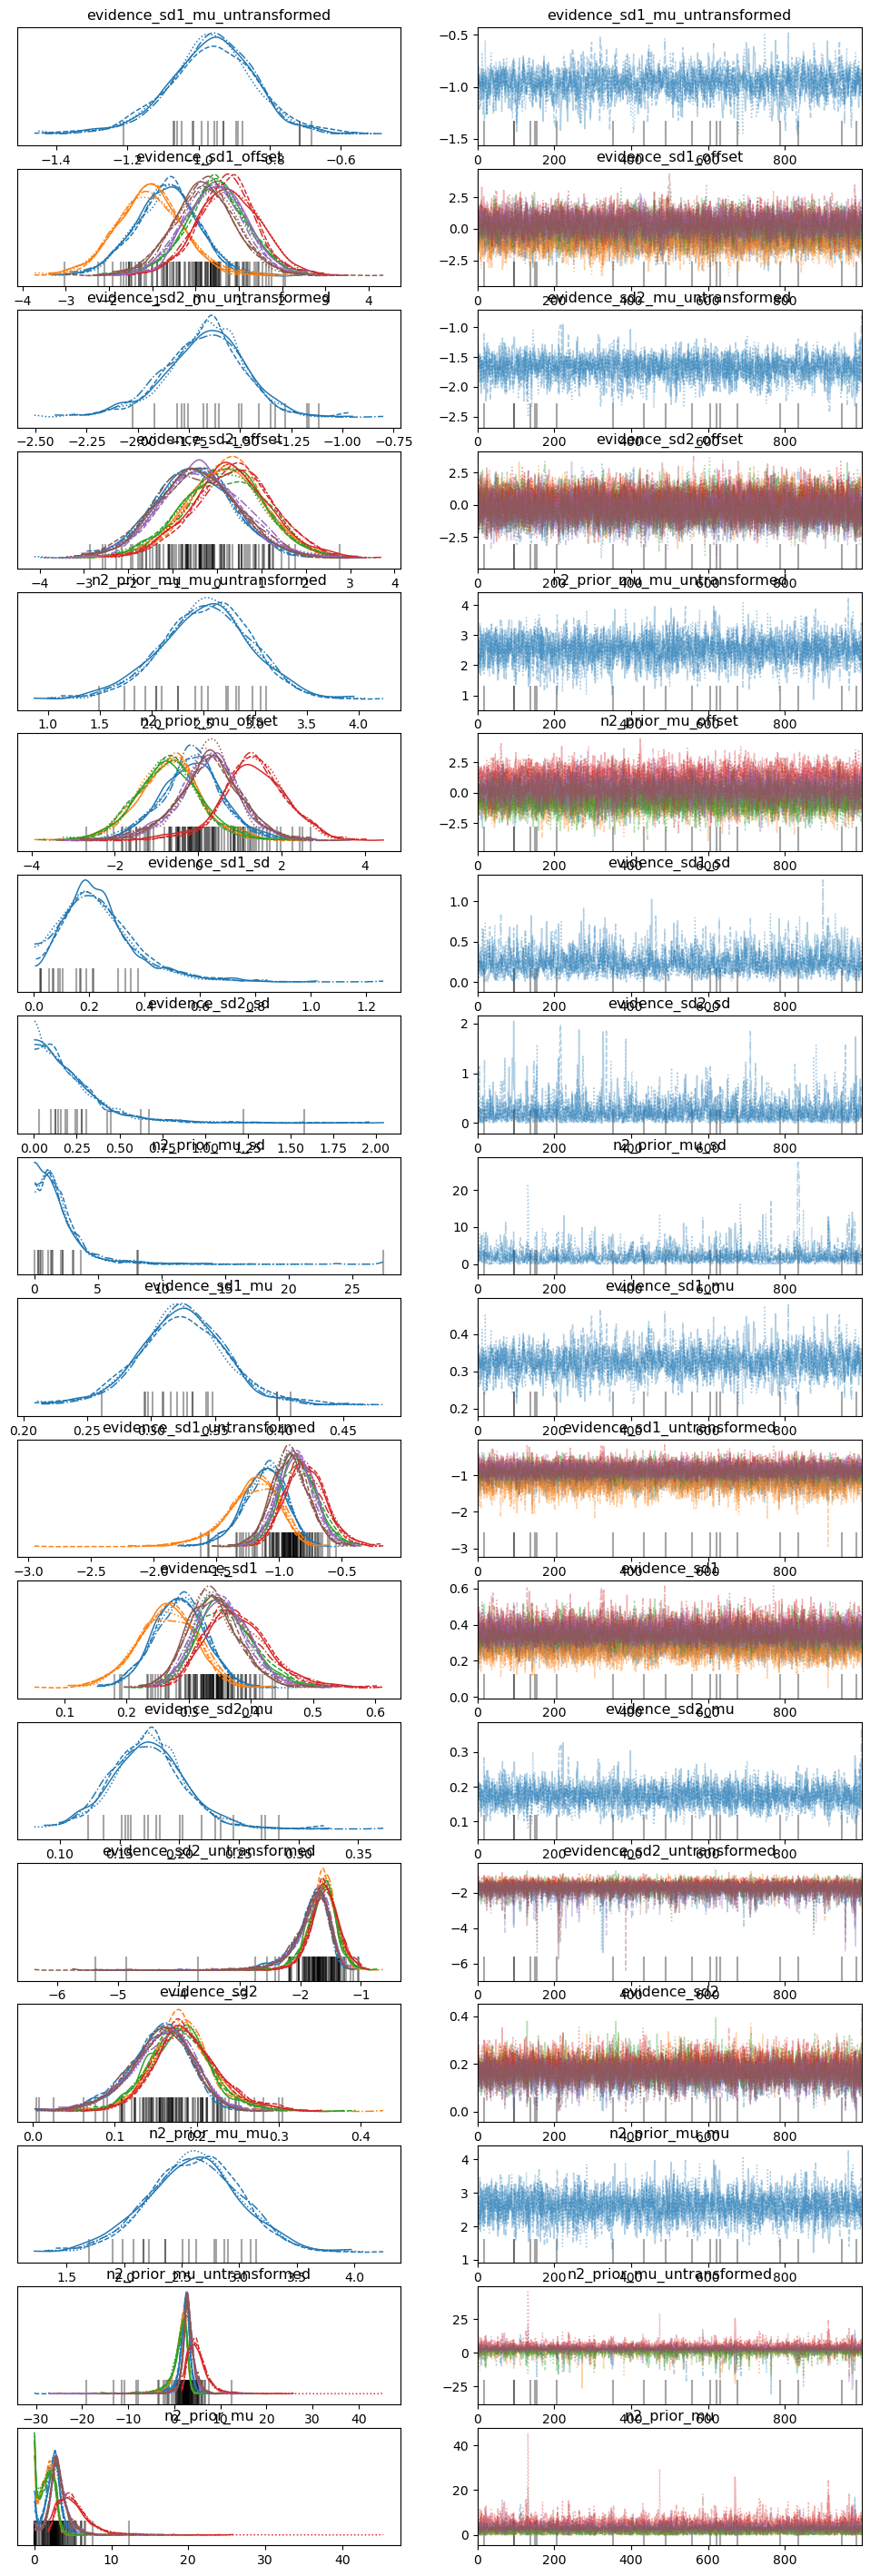

In [9]:
az.plot_trace(trace, var_names=['~p'])

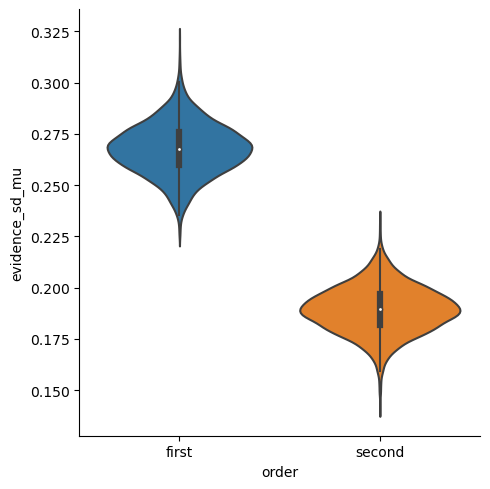

In [ ]:
evidence_sd_mu1 = trace.posterior['evidence_sd1_mu'].to_dataframe()
evidence_sd_mu2 = trace.posterior['evidence_sd2_mu'].to_dataframe()
evidence_sd_mu1.columns = evidence_sd_mu2.columns = ['evidence_sd_mu']
evidence_sd_mu = pd.concat((evidence_sd_mu1, evidence_sd_mu2), keys=['first', 'second'], names=['order'])

sns.catplot(evidence_sd_mu.reset_index(), x='order', y='evidence_sd_mu', kind='violin')

In [26]:
np.log(df['n1'] / df['n2']).max()

1.252762968495368

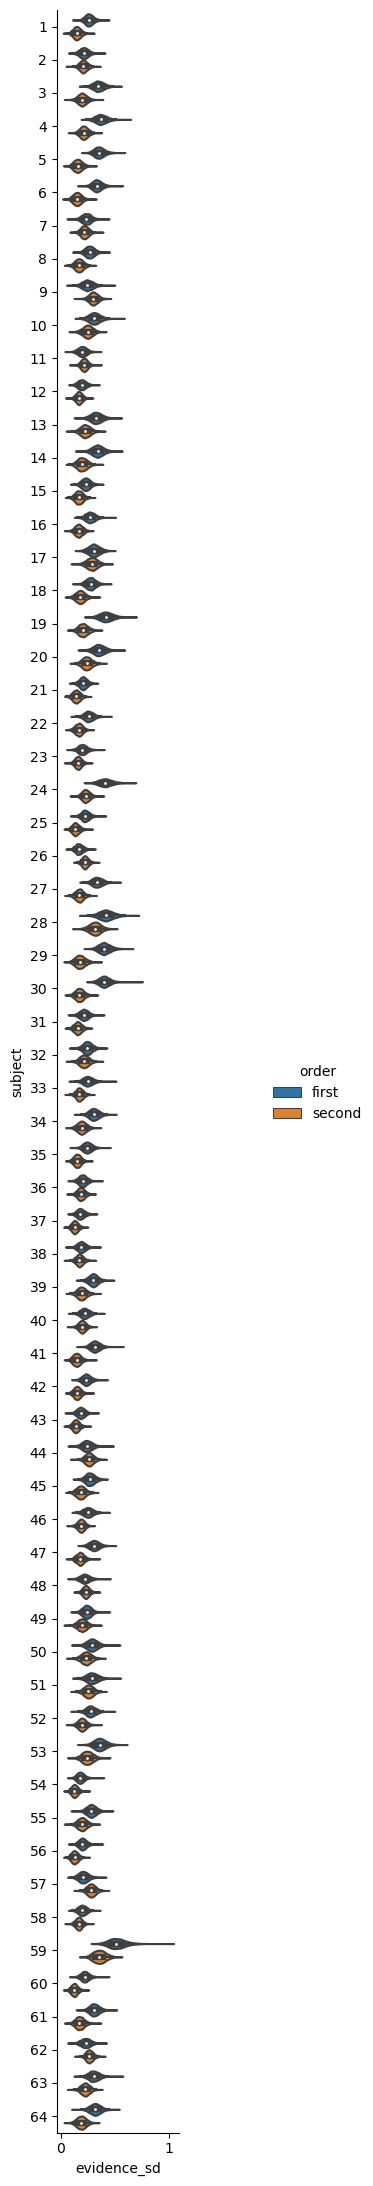

In [ ]:
evidence_sd = trace.posterior['evidence_sd'].to_dataframe()
evidence_sd = evidence_sd.reset_index()
evidence_sd['subject'] = pd.Categorical(evidence_sd['subject'])

# evidence_sd = evidence_sd.set_index('subject')
fac = sns.catplot(x='evidence_sd', y='subject', data=evidence_sd, hue='order', aspect=1/3., size=50, kind='violin')

fac.figure.set_size_inches(5, 25)

In [ ]:
import matplotlib.pyplot as plt

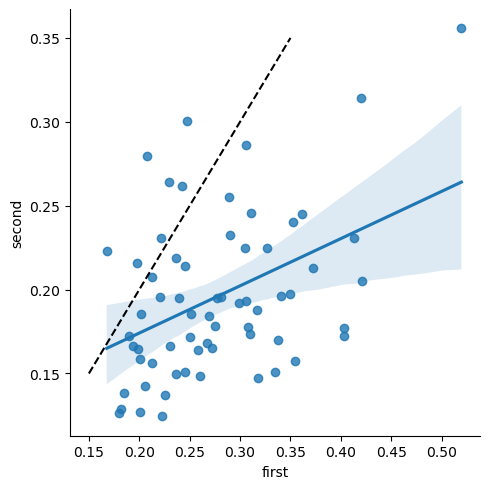

In [ ]:
evidence_sd = trace.posterior['evidence_sd'].to_dataframe()
sns.lmplot(x='first', y='second', data=evidence_sd.unstack('order')['evidence_sd'].groupby(['subject']).mean())
plt.plot([.15, .35], [.15, .35], c='k', ls='--')

In [ ]:
import pingouin
pingouin.corr(*evidence_sd.unstack('order')['evidence_sd'].groupby(['subject']).mean().values.T)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,n,r,CI95%,p-val,BF10,power
pearson,64,0.425792,"[0.2, 0.61]",0.000452,63.818,0.946952


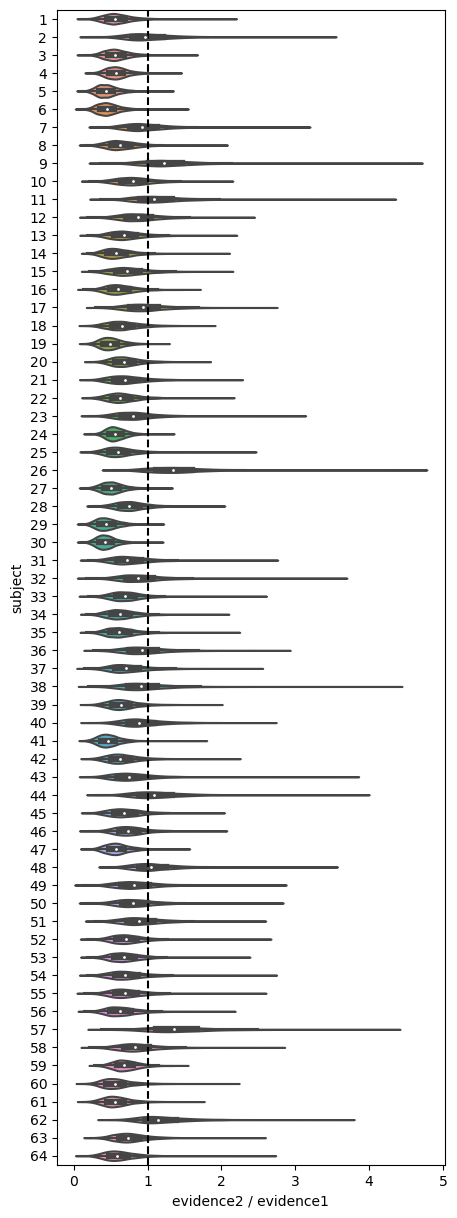

In [ ]:
tmp = evidence_sd.unstack('order').droplevel(0, 1)

tmp = (tmp['second'] / tmp['first']).to_frame('evidence2 / evidence1').reset_index()
tmp['subject'] = pd.Categorical(tmp['subject'])

fac = sns.violinplot(data=tmp, x='evidence2 / evidence1', y='subject', kind='violin', aspect=3)
fac.figure.set_size_inches(5, 15)

plt.axvline(1.0, c='k', ls='--')

In [ ]:
df['x'] = np.log(df['n2'] / df['n1'])

## Subject 5 and 30 should show particularly large regression effects

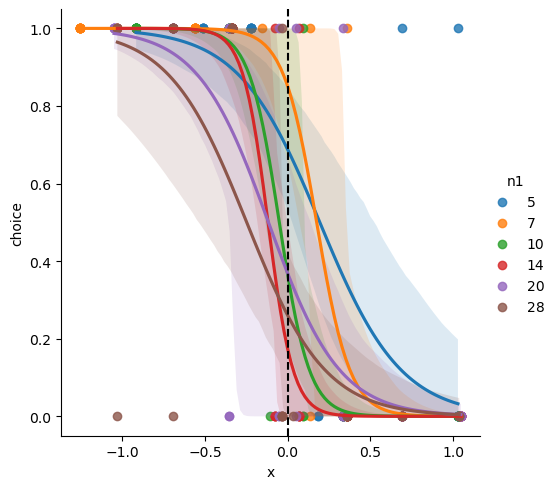

In [ ]:
sns.lmplot(data=df.loc[5], x='x', y='choice', logistic=True, hue='n1')
plt.axvline(0.0, c='k', ls='--')

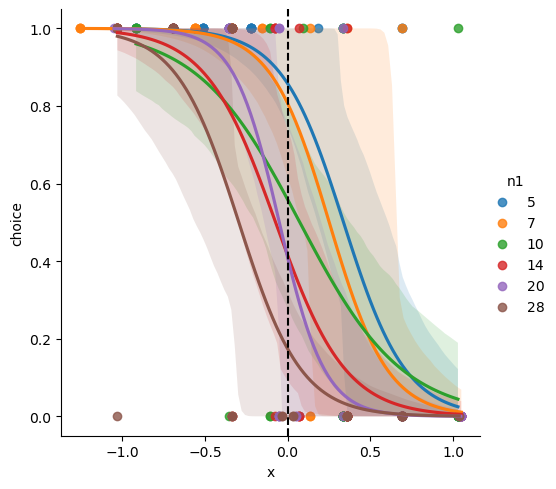

In [ ]:
sns.lmplot(data=df.loc[30], x='x', y='choice', logistic=True, hue='n1')
plt.axvline(0.0, c='k', ls='--')

## 2 and 7 shouldn't

/Users/gdehol/mambaforge/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


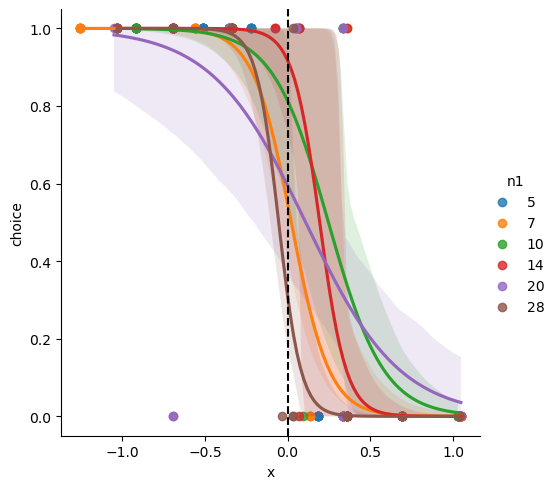

In [ ]:
sns.lmplot(data=df.loc[2], x='x', y='choice', logistic=True, hue='n1')
plt.axvline(0.0, c='k', ls='--')


/Users/gdehol/mambaforge/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


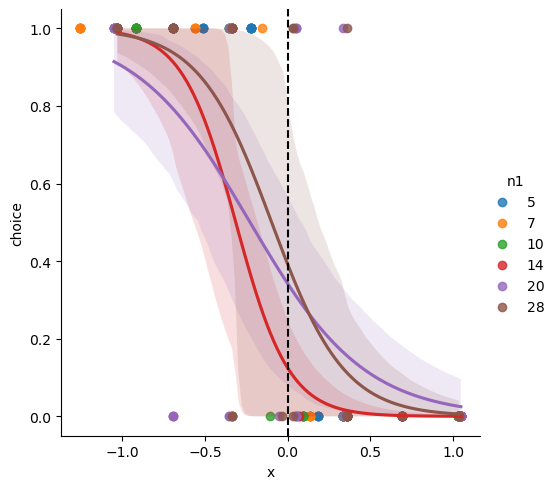

In [ ]:
sns.lmplot(data=df.loc[7], x='x', y='choice', logistic=True, hue='n1')
plt.axvline(0.0, c='k', ls='--')


In [ ]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data